# Intro
This project aims to identify application protocols using only NetFlow data. NetFlow provides detailed network traffic statistics but lacks direct protocol information. By analyzing flow attributes such as IP addresse ranges, packet count, packet size and durations, the goal is to apply unsupervised learning to automatically infer the underlying application protocols. This approach could help network administrators and security professionals gain deeper insights into traffic patterns and improve network management and security.

# Dependencies

In [210]:
!pip install seaborn numpy pandas matplotlib scikit-learn tqdm


[notice] A new release of pip available: 22.3.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [513]:
import numpy as np
import pandas as pd
import seaborn as sns

from itertools import permutations 

import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.model_selection import train_test_split, KFold

from sklearn.cluster import KMeans, DBSCAN, HDBSCAN
from sklearn.decomposition import NMF, PCA

from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score, v_measure_score, \
                            fowlkes_mallows_score, homogeneity_score, completeness_score, make_scorer


# Loading data

In [212]:
df = pd.read_csv("./Dataset-Unicauca-Version2-87Atts.csv")

In [213]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3577296 entries, 0 to 3577295
Data columns (total 87 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   Flow.ID                      object 
 1   Source.IP                    object 
 2   Source.Port                  int64  
 3   Destination.IP               object 
 4   Destination.Port             int64  
 5   Protocol                     int64  
 6   Timestamp                    object 
 7   Flow.Duration                int64  
 8   Total.Fwd.Packets            int64  
 9   Total.Backward.Packets       int64  
 10  Total.Length.of.Fwd.Packets  int64  
 11  Total.Length.of.Bwd.Packets  float64
 12  Fwd.Packet.Length.Max        int64  
 13  Fwd.Packet.Length.Min        int64  
 14  Fwd.Packet.Length.Mean       float64
 15  Fwd.Packet.Length.Std        float64
 16  Bwd.Packet.Length.Max        int64  
 17  Bwd.Packet.Length.Min        int64  
 18  Bwd.Packet.Length.Mean       float64
 19  

In [214]:
df.shape

(3577296, 87)

# Data Cleaning

In [215]:
unique_values = df.nunique()
redundant_columns = unique_values[unique_values == 1].index # Columns which have the same values for all records
redundant_columns

Index(['Bwd.PSH.Flags', 'Fwd.URG.Flags', 'Bwd.URG.Flags', 'CWE.Flag.Count',
       'Fwd.Avg.Bytes.Bulk', 'Fwd.Avg.Packets.Bulk', 'Fwd.Avg.Bulk.Rate',
       'Bwd.Avg.Bytes.Bulk', 'Bwd.Avg.Packets.Bulk', 'Bwd.Avg.Bulk.Rate',
       'Label'],
      dtype='object')

In [216]:
df = df.drop(redundant_columns, axis=1)

In [217]:
df['ProtocolName'].value_counts().head(20) # Top apps in the dataset, we will pick a subset of them to focus on


ProtocolName
GOOGLE            959110
HTTP              683734
HTTP_PROXY        623210
SSL               404883
HTTP_CONNECT      317526
YOUTUBE           170781
AMAZON             86875
MICROSOFT          54710
GMAIL              40260
WINDOWS_UPDATE     34471
SKYPE              30657
FACEBOOK           29033
DROPBOX            25102
YAHOO              21268
TWITTER            18259
CLOUDFLARE         14737
MSN                14478
CONTENT_FLASH       8589
APPLE               7615
OFFICE_365          5941
Name: count, dtype: int64

In [218]:
# Only keep these apps
#apps = ['GOOGLE','YOUTUBE','AMAZON','MICROSOFT','GMAIL','FACEBOOK','TWITTER','WHATSAPP']
apps = ['AMAZON','MICROSOFT','GMAIL','FACEBOOK']
df = df[df['ProtocolName'].apply(lambda s: s in apps)]

In [219]:
# Replace source & dest IPs with binary variables of "is_internal"
internal_prefixes = ['192.168','172.','10.']
df['Source.IP_internal'] = df['Source.IP'].apply(lambda ip: any([ip.startswith(prefix) for prefix in internal_prefixes]))
df['Destination.IP_internal'] = df['Destination.IP'].apply(lambda ip: any([ip.startswith(prefix) for prefix in internal_prefixes]))
df = df.drop(['Source.IP','Destination.IP'], axis=1)
df

,Flow.ID,Source.Port,Destination.Port,Protocol,Timestamp,Flow.Duration,Total.Fwd.Packets,Total.Backward.Packets,Total.Length.of.Fwd.Packets,Total.Length.of.Bwd.Packets,...,Active.Max,Active.Min,Idle.Mean,Idle.Std,Idle.Max,Idle.Min,L7Protocol,ProtocolName,Source.IP_internal,Destination.IP_internal
100,157.240.0.22-10.200.7.217-443-53809-6,53809,443,6,26/04/201711:11:18,1,2,0,0,0.0,...,0.0,0.0,0.0,0.000000e+00,0.0,0.0,119,FACEBOOK,True,False
272,192.168.151.4-10.200.7.5-51444-3128-6,51444,3128,6,26/04/201711:11:19,14276,5,17,233,8900.0,...,0.0,0.0,0.0,0.000000e+00,0.0,0.0,119,FACEBOOK,True,True
273,192.168.151.4-10.200.7.5-51443-3128-6,51443,3128,6,26/04/201711:11:19,15072,5,16,233,8900.0,...,0.0,0.0,0.0,0.000000e+00,0.0,0.0,119,FACEBOOK,True,True
285,192.168.151.4-10.200.7.5-51445-3128-6,51445,3128,6,26/04/201711:11:20,3703,5,16,233,8900.0,...,0.0,0.0,0.0,0.000000e+00,0.0,0.0,119,FACEBOOK,True,True
316,10.200.7.194-52.1.215.98-39111-443-6,39111,443,6,26/04/201711:11:18,1670884,5,8,580,14951.0,...,0.0,0.0,0.0,0.000000e+00,0.0,0.0,178,AMAZON,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3576898,10.200.7.217-64.233.190.189-57682-443-6,443,57682,6,15/05/201705:35:16,328,1,2,0,0.0,...,0.0,0.0,0.0,0.000000e+00,0.0,0.0,122,GMAIL,False,True
3576943,10.200.7.194-64.233.190.189-44795-443-6,443,44795,6,15/05/201705:38:33,74956125,9,10,361,263.0,...,928344.0,1.0,24675815.0,2.909996e+05,24995402.0,24426139.0,122,GMAIL,False,True
3577033,10.200.7.194-64.233.190.189-44795-443-6,443,44795,6,15/05/201705:40:17,108243326,5,5,260,0.0,...,4307.0,58.0,27059568.0,2.419064e+06,29959004.0,24457039.0,122,GMAIL,False,True
3577096,10.200.7.194-64.233.190.189-44795-443-6,443,44795,6,15/05/201705:42:32,112893912,9,7,413,225.0,...,583700.0,114.0,28077439.5,1.905507e+06,29911982.0,25824965.0,122,GMAIL,False,True


In [220]:
# Remove timestamp, Flow.ID, and port numbers (because we're dealing with web-apps the ports don't tell us much)
df = df.drop(['Flow.ID','Timestamp', 'Source.Port', 'Destination.Port'], axis=1)

In [221]:
df['Protocol'].value_counts() # We might have some wrong records since all values should be 6, let's clean them up

Protocol
6     210826
17        52
Name: count, dtype: int64

In [222]:
df = df[df['Protocol'] == 6] # We will only deal with TCP traffic
df = df.drop('Protocol', axis=1)

# Exploratory Data Analysis

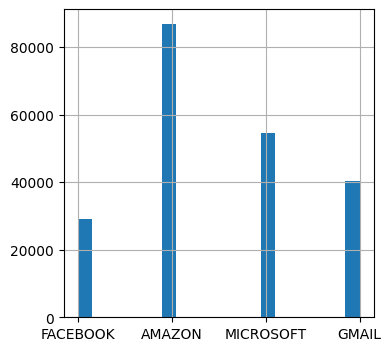

In [226]:
# Class distribution

plt.figure(figsize=(4,4))
df['ProtocolName'].hist(bins=20)
plt.show()

<Axes: >

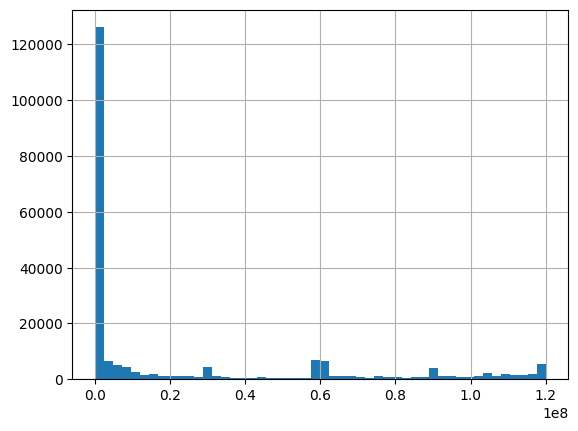

In [224]:
df['Flow.Duration'].hist(bins=50)

In [244]:
# Fetching fields which have the strongest correlations with any specific protocol name as the features basis for prediction

df_cat = pd.concat([pd.get_dummies(df['ProtocolName']), df.drop('ProtocolName',axis=1)], axis=1)
key_fields = df_cat.corr().loc[list(set(df_cat.columns)-set(apps)), apps].max(axis=1).sort_values(ascending=False).head(20).index
key_fields

Index(['L7Protocol', 'min_seg_size_forward', 'Bwd.IAT.Total', 'Idle.Max',
       'Destination.IP_internal', 'Idle.Mean', 'Bwd.IAT.Max', 'Flow.IAT.Min',
       'Idle.Min', 'Bwd.Packet.Length.Std', 'SYN.Flag.Count', 'Fwd.PSH.Flags',
       'Fwd.IAT.Total', 'Idle.Std', 'Flow.Duration', 'Bwd.Packet.Length.Max',
       'Bwd.Packet.Length.Mean', 'Avg.Bwd.Segment.Size', 'Packet.Length.Std',
       'Bwd.IAT.Std'],
      dtype='object')

# PreProcessing

Since we'll be using NMF, it's a good idea to replace missing values that are marked with '-1' with '0' instead, especially since in that column there are no 0 values that are valid

In [245]:
df.loc[df['Init_Win_bytes_backward'] == -1, 'Init_Win_bytes_backward'] = 0 # Replace -1 with 0's for missing values

We've seen the classes are highly imbalance, let's re-balance by undersampling in order to prevent from one cluster dominating the others in our model

In [246]:
min_class_size = df.groupby('ProtocolName').count().min().iloc[0]
min_class_size

29033

In [431]:
max_class_size = 10_000

subsample_size = min(max_class_size, min_class_size)

In [432]:
subsample_size

10000

In [433]:
dfs = []
for cl in df['ProtocolName'].unique():
    class_sample = df[df['ProtocolName'] == cl].sample(n=subsample_size)
    dfs += [class_sample]

In [434]:
df = pd.concat(dfs)

In [435]:
df = df.reset_index().drop('index', axis=1)

In [538]:
#X = df.drop('ProtocolName', axis=1)
X = df[key_fields]
#X = df[['Flow.Duration','Total.Fwd.Packets','Total.Backward.Packets','Source.IP_internal','Destination.IP_internal']].values
y = list(df['ProtocolName'].values)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [539]:
# scaler = RobustScaler(with_centering=False) # Disabled centering to avoid negative values for NMF
#scaler = MinMaxScaler()
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

# Model Training

In [540]:
# pca = PCA(n_components=10)
# pca.fit(X_train)
# print(pca.explained_variance_ratio_.sum())

In [541]:
#X_train = pca.transform(X_train)
#X_test = pca.transform(X_test)

## Hyperparameters tuning

Testing eps values:   0%|          | 0/5 [00:00<?, ?it/s]

Testing min_samples:   0%|          | 0/1 [00:00<?, ?it/s]

eps: 0.7, min_samples: 2, ARI: 0.3481271713044187


Testing min_samples:   0%|          | 0/1 [00:00<?, ?it/s]

eps: 0.75, min_samples: 2, ARI: 0.35292964148044337


Testing min_samples:   0%|          | 0/1 [00:00<?, ?it/s]

eps: 0.8, min_samples: 2, ARI: 0.3571344947083267


Testing min_samples:   0%|          | 0/1 [00:00<?, ?it/s]

eps: 0.85, min_samples: 2, ARI: 0.36038633374480383


Testing min_samples:   0%|          | 0/1 [00:00<?, ?it/s]

Best Parameters: {'eps': 0.85, 'min_samples': 2}
Best ARI Score: 0.36038633374480383


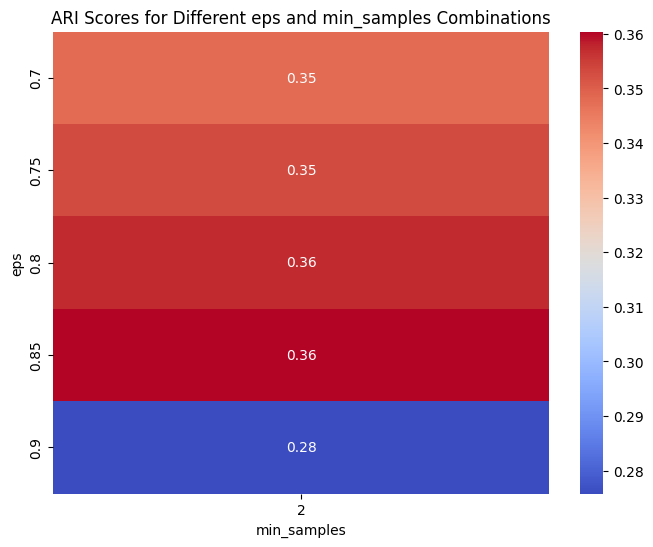

In [575]:
eps_values = np.linspace(0.7, 0.9, 5)
min_samples_values = np.arange(2, 3, 1)

best_ari = -1
best_params = {}
ari_scores = []

for eps in tqdm(eps_values, desc="Testing eps values", position=0, leave=True):
    ari_row = []
    for min_samples in tqdm(min_samples_values, desc="Testing min_samples", position=1, leave=False):
        dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean')
        y_pred = dbscan.fit_predict(X_train)
        ari = adjusted_rand_score(y_train, y_pred)
        ari_row.append(ari)

        # Update the best ARI score and parameters if the current ARI is better
        if ari > best_ari:
            best_ari = ari
            best_params = {'eps': eps, 'min_samples': min_samples}
            print(f"eps: {eps}, min_samples: {min_samples}, ARI: {ari}")

    
    ari_scores.append(ari_row)

# Print the best parameters and the best ARI score
print(f"Best Parameters: {best_params}")
print(f"Best ARI Score: {best_ari}")

ari_scores = np.array(ari_scores)

# Create a heatmap using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(ari_scores, annot=True, cmap='coolwarm', xticklabels=min_samples_values, yticklabels=eps_values)

# Labels and title
plt.xlabel('min_samples')
plt.ylabel('eps')
plt.title('ARI Scores for Different eps and min_samples Combinations')

# Display the plot
plt.show()


In [576]:
# eps_values = np.linspace(0.5, 2, 5)
# min_samples_values = np.arange(2, 5, 1)

# best_ari = -1
# best_params = {}
# ari_scores = []

# # Set up K-fold cross-validation
# kf = KFold(n_splits=5, shuffle=True, random_state=42)

# # Loop through the hyperparameter grid
# for eps in tqdm(eps_values, desc="Testing eps values", position=0, leave=True):
#     ari_row = []
#     for min_samples in tqdm(min_samples_values, desc="Testing min_samples", position=1, leave=False):
#         fold_ari_scores = []

#         # Perform cross-validation
#         for train_idx, val_idx in kf.split(X_train):
#             X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
#             y_train_fold, y_val_fold = [y_train[i] for i in train_idx], [y_train[i] for i in val_idx]  # List indexing

#             dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean')
#             # Fit on training data and predict on validation data
#             y_pred_val = dbscan.fit_predict(X_val_fold)

         
#             # Create a DataFrame for results with the true labels and predicted clusters
#             results = pd.concat([pd.Series(y_train_fold, name='ProtocolName'), pd.Series(y_pred_val, name='cluster')], axis=1)
            
#             # Map clusters to the most common protocol name for each cluster
#             cluster_protocol_map = results.groupby('cluster')['ProtocolName'].agg(lambda x: x.mode()[0]).to_dict()

#             # Map predicted clusters to labels using the map
#             y_pred_val_mapped = [cluster_protocol_map.get(y, 'None') for y in y_pred_val]

#             # Calculate ARI for the current fold (using validation labels and predicted labels)
#             ari = adjusted_rand_score(y_val_fold, y_pred_val_mapped)
#             fold_ari_scores.append(ari)

#         # Calculate average ARI score for the current hyperparameter combination
#         avg_ari = np.mean(fold_ari_scores)
#         ari_row.append(avg_ari)

#         # Update the best ARI score and parameters if the current ARI is better
#         if avg_ari > best_ari:
#             best_ari = avg_ari
#             best_params = {'eps': eps, 'min_samples': min_samples}
#             print(f"eps: {eps}, min_samples: {min_samples}, ARI: {avg_ari}")

#     ari_scores.append(ari_row)

# # Print the best parameters and the best ARI score
# print(f"Best Parameters: {best_params}")
# print(f"Best ARI Score: {best_ari}")

# ari_scores = np.array(ari_scores)

# # Create a heatmap using seaborn
# plt.figure(figsize=(8, 6))
# sns.heatmap(ari_scores, annot=True, cmap='coolwarm', xticklabels=min_samples_values, yticklabels=eps_values)

# # Labels and title
# plt.xlabel('min_samples')
# plt.ylabel('eps')
# plt.title('ARI Scores for Different eps and min_samples Combinations')

# # Display the plot
# plt.show()


In [577]:
model = DBSCAN(eps=best_params['eps'], min_samples=best_params['min_samples'], metric='euclidean')
y_pred = dbscan.fit_predict(X_train)

In [578]:
# model = KMeans(n_clusters=len(df['ProtocolName'].unique()))
# y_pred = np.argmax(model.fit_transform(X_train), axis=1)

In [579]:
# model = NMF(n_components=len(df['ProtocolName'].unique()))
# W = model.fit_transform(X_train)
# y_pred = W.argmax(axis=1)

In [580]:
# model = HDBSCAN(min_cluster_size=100)
# y_pred = model.fit_predict(X_train)

In [581]:

results = pd.concat([pd.Series(y_train, name='ProtocolName'), pd.Series(y_pred, name='cluster').reset_index(drop=True)], axis=1, ignore_index=False)
results

,ProtocolName,cluster
0,GMAIL,-1
1,AMAZON,0
2,AMAZON,1
3,AMAZON,1
4,GMAIL,2
...,...,...
31995,AMAZON,1
31996,MICROSOFT,-1
31997,GMAIL,5
31998,AMAZON,1


# Evaluation

In [582]:
cluster_proto_counts = pd.DataFrame(results.groupby('cluster')['ProtocolName'].value_counts()).reset_index().pivot(index='cluster', columns='ProtocolName', values='count')
cluster_proto_counts

ProtocolName,AMAZON,FACEBOOK,GMAIL,MICROSOFT
cluster,,,,
-1,646.0,141.0,1235.0,480.0
0,120.0,NaN,NaN,189.0
1,5447.0,NaN,NaN,3565.0
2,NaN,NaN,56.0,NaN
3,552.0,NaN,NaN,3087.0
...,...,...,...,...
537,NaN,NaN,NaN,2.0
538,NaN,2.0,NaN,NaN
539,NaN,NaN,2.0,NaN


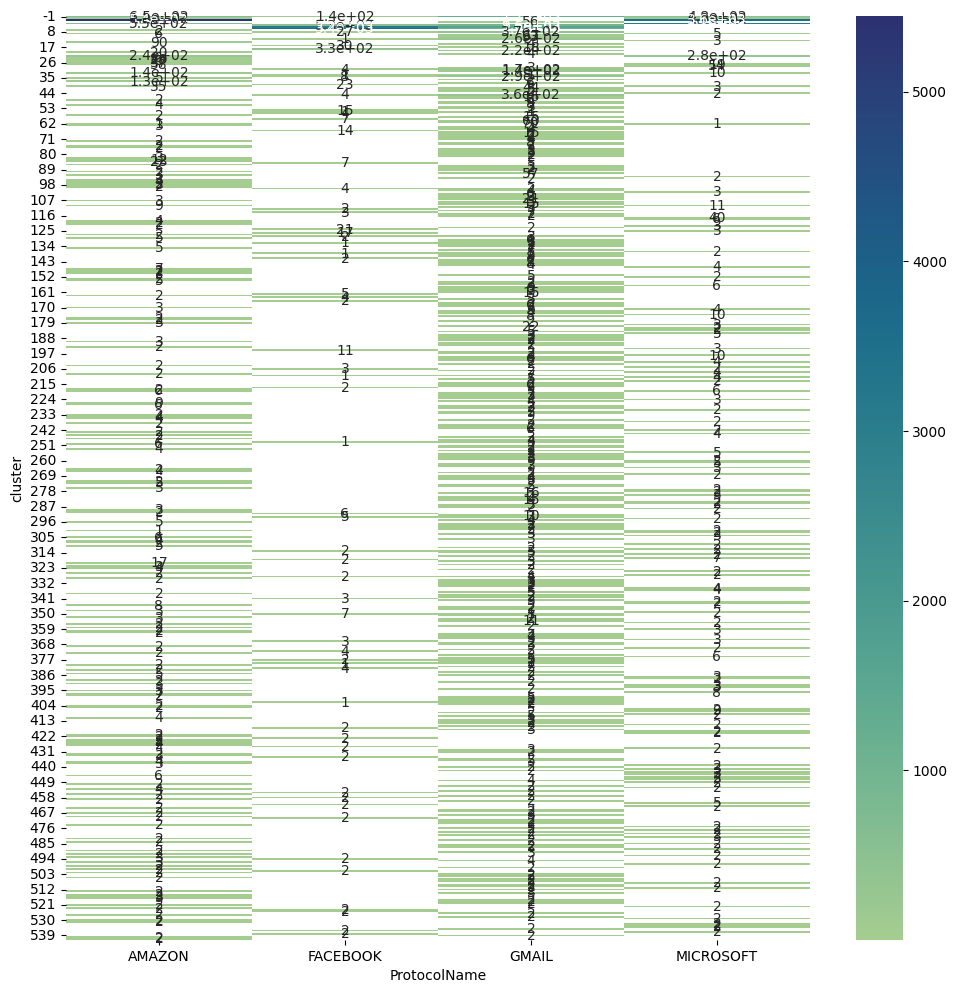

In [583]:
plt.figure(figsize=(12,12))
sns.heatmap(cluster_proto_counts, cmap='crest', annot=True)
plt.show()

In [584]:
true_labels = results.iloc[:,0]
predicted_labels = results.iloc[:,1]


ari = adjusted_rand_score(true_labels, predicted_labels)
print(f"Adjusted Rand Index (ARI): {ari:.4f}")

nmi = normalized_mutual_info_score(true_labels, predicted_labels)
print(f"Normalized Mutual Information (NMI): {nmi:.4f}")

v_measure = v_measure_score(true_labels, predicted_labels)
print(f"V-Measure: {v_measure:.4f}")

fmi = fowlkes_mallows_score(true_labels, predicted_labels)
print(f"Fowlkes-Mallows Index (FMI): {fmi:.4f}")

homogeneity = homogeneity_score(true_labels, predicted_labels)
completeness = completeness_score(true_labels, predicted_labels)
print(f"Homogeneity: {homogeneity:.4f}")
print(f"Completeness: {completeness:.4f}")

Adjusted Rand Index (ARI): 0.2758
Normalized Mutual Information (NMI): 0.4061
V-Measure: 0.4061
Fowlkes-Mallows Index (FMI): 0.4239
Homogeneity: 0.5935
Completeness: 0.3087


## Test set

In [585]:
X_test = scaler.fit_transform(X_test)
y_test_pred = model.fit_predict(X_test)

cluster_protocol_map = results.groupby('cluster')['ProtocolName'].agg(lambda x: x.mode()[0]).to_dict()
y_test_pred = [(cluster_protocol_map[y]  if y in cluster_protocol_map else 'None') for y in y_test_pred]

In [586]:
accuracy_score(y_test_pred, y_test)

0.352

In [562]:
# TODO: Change hyper-parameter tuning to work on cross-validation set, because tuning might be overfitting
# TODO: compare to random forest or gbm